# Simulation Playground Notebook
This notebook is designed as a easy einterface to call the functions that we have defined

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import torch.optim as optim
import torch.nn as nn
import torch

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import load_participants_info, load_event_descriptions, load_behavioral_data, preprocess_data
from LCModels import LCNECortexFCN, LCNECortexRNN, LCNECortexFitter, FeedForwardNN, RecurrentNet, LCNECortexLSTM
from utils import perform_pca_and_plot

# Untrained Model

Let's defined the two types of models that we have first and run the untrained models

In [2]:
# lambda_cortex = 0.1
# hidden_size = 16

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_FCN = LCNECortexFCN(lambda_cortex).to(device)
# model_RNN = LCNECortexRNN(hidden_size).to(device)

# time_steps = 100
# conditions = ["baseline", "acute_stress", "chronic_stress", "top_down_control"]
# {cond: run_simulation(model_FCN, device, time_steps, cond) for cond in conditions}

# Data Preparation
Let's prepare some data first to fit our model. We are specifically using ["Locus coeruleus activity strengthens prioritized memories under arousal"](https://openneuro.org/datasets/ds002011/versions/1.0.0) dataset fror now.

In [3]:
DATASET_PATH = "data"
participants_df = load_participants_info(DATASET_PATH)
load_event_descriptions(DATASET_PATH)

df_behavior = load_behavioral_data(DATASET_PATH, "01")
for idx in range(2,11):
    sample_participant = f"0{idx}"
    df = load_behavioral_data(DATASET_PATH, sample_participant)
    df_behavior = pd.concat([df, df_behavior], ignore_index=True)

Let's preprocess our data first

In [4]:
X, Y, X_tensor, Y_tensor, scaler_X, scaler_Y, df_clean = preprocess_data(df_behavior)

X Shape: torch.Size([1699, 7]), Y Shape: torch.Size([1699])
Y Min: -1.0, Y Max: 1.0


# Training

## Baseline Fully Connected Neural Network

To illustrate our idea, we want to train 2 models from math and computer science, which is our vanilla feed forward networks and an recurrent networks.

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

input_size = X_tensor.shape[1]
model_ff = FeedForwardNN(input_size)
optimizer = optim.Adam(model_ff.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model_ff(X_train)
    loss = loss_fn(Y_pred, Y_train.view(-1, 1))
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.19706298410892487
Epoch 100, Loss: 0.05000227317214012
Epoch 200, Loss: 0.04828350618481636
Epoch 300, Loss: 0.04751618206501007
Epoch 400, Loss: 0.047020550817251205
Epoch 500, Loss: 0.04641630873084068
Epoch 600, Loss: 0.0459514856338501
Epoch 700, Loss: 0.045566439628601074
Epoch 800, Loss: 0.04530845209956169
Epoch 900, Loss: 0.045029398053884506


Let's check the performance of it fitting the data

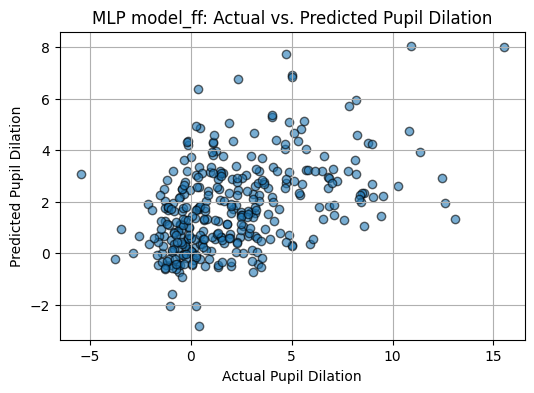

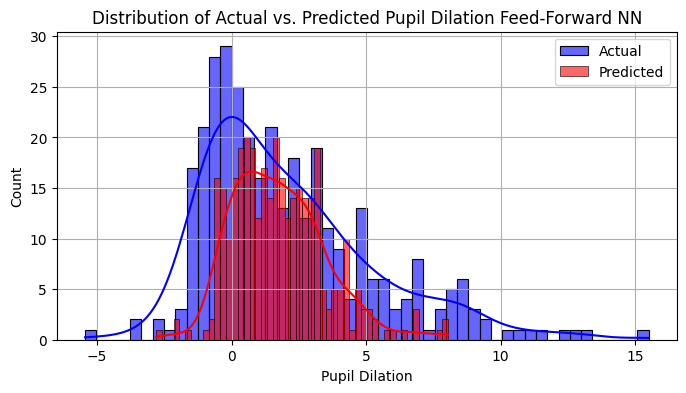

Pearson Correlation: 0.4495


In [6]:
with torch.no_grad():
    Y_test_pred = model_ff(X_test)

Y_test_pred = scaler_Y.inverse_transform(Y_test_pred.cpu().numpy())
Y_test_actual = scaler_Y.inverse_transform(Y_test.cpu().numpy().reshape(-1, 1))

plt.figure(figsize=(6, 4))
plt.scatter(Y_test_actual, Y_test_pred, alpha=0.6, edgecolors="k")
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Predicted Pupil Dilation")
plt.title("MLP model_ff: Actual vs. Predicted Pupil Dilation")
plt.grid(True)
plt.show()

df_predictions = pd.DataFrame({'PupilPred': Y_test_pred.flatten()})
df_actual = pd.DataFrame({'Event_PupilDilation': Y_test_actual.flatten()})

plt.figure(figsize=(8, 4))
sns.histplot(df_actual['Event_PupilDilation'], kde=True, label="Actual", color='blue', alpha=0.6, bins=50)
sns.histplot(df_predictions['PupilPred'], kde=True, label="Predicted", color='red', alpha=0.6, bins=50)

plt.xlabel("Pupil Dilation")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Pupil Dilation Feed-Forward NN")
plt.grid(True)
plt.show()

corr, _ = pearsonr(df_actual['Event_PupilDilation'], df_predictions['PupilPred'])
print(f"Pearson Correlation: {corr:.4f}")

## Baseline Recurent Networks

We will  do the same thing with an recurrent neural network

In [7]:
# Convert input data into sequences
X_rnn = X_tensor.unsqueeze(1) 
Y_rnn = Y_tensor.unsqueeze(1) 

print(f"X_rnn Shape: {X_rnn.shape}, Y_rnn Shape: {Y_rnn.shape}")

model_rnn = RecurrentNet(input_size=X_rnn.shape[2])
optimizer = optim.Adam(model_rnn.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model_rnn(X_rnn)
    loss = loss_fn(Y_pred, Y_rnn)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

X_rnn Shape: torch.Size([1699, 1, 7]), Y_rnn Shape: torch.Size([1699, 1])
Epoch 0, Loss: 0.1837
Epoch 100, Loss: 0.0512
Epoch 200, Loss: 0.0502
Epoch 300, Loss: 0.0494
Epoch 400, Loss: 0.0489
Epoch 500, Loss: 0.0486
Epoch 600, Loss: 0.0483
Epoch 700, Loss: 0.0478
Epoch 800, Loss: 0.0477
Epoch 900, Loss: 0.0475
Epoch 1000, Loss: 0.0474
Epoch 1100, Loss: 0.0473
Epoch 1200, Loss: 0.0472
Epoch 1300, Loss: 0.0470
Epoch 1400, Loss: 0.0469
Epoch 1500, Loss: 0.0468
Epoch 1600, Loss: 0.0467
Epoch 1700, Loss: 0.0466
Epoch 1800, Loss: 0.0468
Epoch 1900, Loss: 0.0464


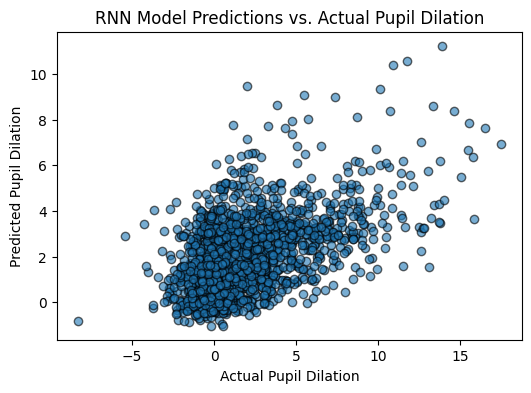

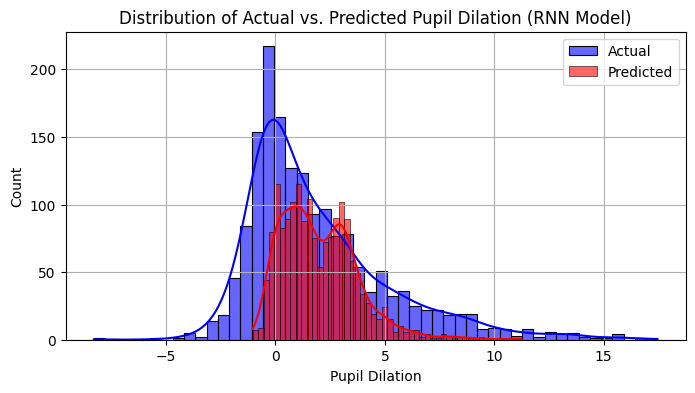

Pearson Correlation: 0.5300


In [8]:
with torch.no_grad():
    Y_pred_rnn = model_rnn(X_rnn)

df_predictions = pd.DataFrame({'PupilPred': scaler_Y.inverse_transform(Y_pred_rnn.cpu().numpy().reshape(-1, 1)).squeeze()})
df_actual = df_clean[['Event_PupilDilation']].reset_index(drop=True)

plt.figure(figsize=(6,4))
plt.scatter(df_actual['Event_PupilDilation'], df_predictions['PupilPred'], alpha=0.6, edgecolors="k")
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Predicted Pupil Dilation")
plt.title("RNN Model Predictions vs. Actual Pupil Dilation")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_actual['Event_PupilDilation'], kde=True, label="Actual", color='blue', alpha=0.6, bins=50)
sns.histplot(df_predictions['PupilPred'], kde=True, label="Predicted", color='red', alpha=0.6, bins=50)

plt.xlabel("Pupil Dilation")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Pupil Dilation (RNN Model)")
plt.grid(True)
plt.show()

corr, _ = pearsonr(df_actual['Event_PupilDilation'], df_predictions['PupilPred'])
print(f"Pearson Correlation: {corr:.4f}")

## Customized LCNECortex Model

Now coming to our customized LCNECortex model

In [9]:
# Initialize model_lc
input_dim = X_tensor.shape[1]  # Dynamically get input feature size
model_lc = LCNECortexFitter(input_dim=input_dim, hidden_dim=8)
optimizer = optim.Adam(model_lc.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.SmoothL1Loss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

epochs = 5000
batch_size = 32

for epoch in range(epochs):
    optimizer.zero_grad()

    # Sample a batch of data
    idx = torch.randint(0, X_tensor.shape[0], (batch_size,))
    X_batch, Y_batch = X_tensor[idx], Y_tensor[idx]

    # Initialize LC and Cortex states for batch
    prev_LC = torch.zeros(batch_size, 8)  
    prev_Cortex = torch.zeros(batch_size, 8)  

    # Forward pass
    LC_pred, NE_pred, C_pred, Pupil_pred = model_lc(X_batch, prev_LC, prev_Cortex)

    # Compute loss
    loss = loss_fn(Pupil_pred, Y_batch.unsqueeze(1))

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # scheduler.step(loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 0.7635090947151184


/Users/kevinb/miniforge3/envs/cse251b/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 100, Loss: 0.04467618465423584
Epoch 200, Loss: 0.029068544507026672
Epoch 300, Loss: 0.02824895828962326
Epoch 400, Loss: 0.025368163362145424
Epoch 500, Loss: 0.03389791399240494
Epoch 600, Loss: 0.031640224158763885
Epoch 700, Loss: 0.023980196565389633
Epoch 800, Loss: 0.03127220273017883
Epoch 900, Loss: 0.03848510980606079
Epoch 1000, Loss: 0.026291873306035995
Epoch 1100, Loss: 0.022417832165956497
Epoch 1200, Loss: 0.021999984979629517
Epoch 1300, Loss: 0.014351703226566315
Epoch 1400, Loss: 0.01810627058148384
Epoch 1500, Loss: 0.021851835772395134
Epoch 1600, Loss: 0.032123856246471405
Epoch 1700, Loss: 0.022451277822256088
Epoch 1800, Loss: 0.026332860812544823
Epoch 1900, Loss: 0.022558879107236862
Epoch 2000, Loss: 0.018783098086714745
Epoch 2100, Loss: 0.023960299789905548
Epoch 2200, Loss: 0.0254997406154871
Epoch 2300, Loss: 0.03448871523141861
Epoch 2400, Loss: 0.01689431630074978
Epoch 2500, Loss: 0.01604374311864376
Epoch 2600, Loss: 0.01634417474269867
Epoch 2

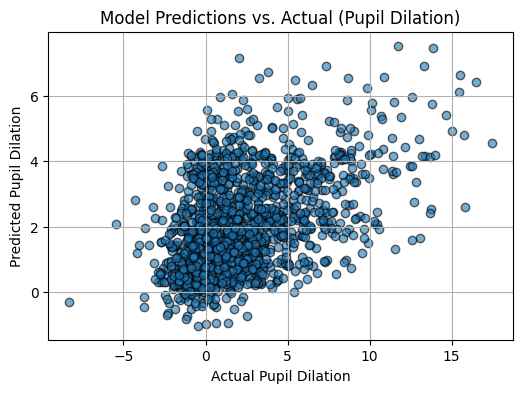

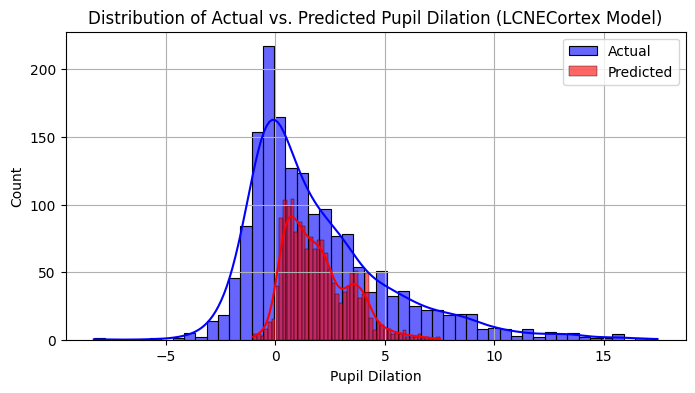

Pearson Correlation: 0.4971


In [10]:
hidden_dim = model_lc.hidden_dim 
batch_size = X_tensor.shape[0]

prev_LC = torch.zeros(batch_size, hidden_dim)  
prev_Cortex = torch.zeros(batch_size, hidden_dim)

with torch.no_grad():
    _, _, _, Pupil_pred = model_lc(X_tensor, prev_LC, prev_Cortex)

df_predictions = pd.DataFrame({'PupilPred': Pupil_pred.squeeze().cpu().numpy()})
df_actual = df_clean[['Event_PupilDilation']].reset_index(drop=True)

if "scaler_Y" in globals():
    # Clip predictions before inverse transformation
    df_predictions['PupilPred'] = np.clip(Pupil_pred.detach().cpu().numpy(), -1, 1)
    df_predictions['PupilPred'] = scaler_Y.inverse_transform(df_predictions[['PupilPred']])


plt.figure(figsize=(6, 4))
plt.scatter(df_actual['Event_PupilDilation'], df_predictions['PupilPred'], alpha=0.6, edgecolors="k")
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Predicted Pupil Dilation")
plt.title("Model Predictions vs. Actual (Pupil Dilation)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_actual['Event_PupilDilation'], kde=True, label="Actual", color='blue', alpha=0.6, bins=50)
sns.histplot(df_predictions['PupilPred'], kde=True, label="Predicted", color='red', alpha=0.6, bins=50)

plt.xlabel("Pupil Dilation")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Pupil Dilation (LCNECortex Model)")
plt.grid(True)
plt.show()

corr, _ = pearsonr(df_actual['Event_PupilDilation'], df_predictions['PupilPred'])
print(f"Pearson Correlation: {corr:.4f}")

# LSTM Style LCNECortex Model

In [11]:
input_dim = X_tensor.shape[1]
hidden_dim = 8
model_lc_lstm = LCNECortexLSTM(input_dim=input_dim, hidden_dim=hidden_dim)
optimizer = optim.Adam(model_lc_lstm.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.SmoothL1Loss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

epochs = 5000
batch_size = 32

for epoch in range(epochs):
    optimizer.zero_grad()

    # Sample a batch of data
    idx = torch.randint(0, X_tensor.shape[0], (batch_size,))
    X_batch, Y_batch = X_tensor[idx], Y_tensor[idx]

    # Initialize LC, Cortex states, and Cell memory
    prev_LC = torch.zeros(batch_size, hidden_dim)
    prev_Cortex = torch.zeros(batch_size, hidden_dim)
    cell_state = torch.zeros(batch_size, hidden_dim)

    LC_pred, NE_pred, C_pred, Pupil_pred, cell_state = model_lc_lstm(X_batch, prev_LC, prev_Cortex, cell_state)
    loss = loss_fn(Pupil_pred, Y_batch.unsqueeze(1))

    loss.backward()
    optimizer.step()
    
    scheduler.step(loss) 

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.3169381618499756


/Users/kevinb/miniforge3/envs/cse251b/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Users/kevinb/miniforge3/envs/cse251b/lib/python3.9/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Epoch 100, Loss: 0.0444800890982151
Epoch 200, Loss: 0.05185110121965408
Epoch 300, Loss: 0.04836530238389969
Epoch 400, Loss: 0.06139588728547096
Epoch 500, Loss: 0.036758653819561005
Epoch 600, Loss: 0.044518113136291504
Epoch 700, Loss: 0.06253249198198318
Epoch 800, Loss: 0.051231756806373596
Epoch 900, Loss: 0.0412699431180954
Epoch 1000, Loss: 0.03713928535580635
Epoch 1100, Loss: 0.06561429798603058
Epoch 1200, Loss: 0.049290549010038376
Epoch 1300, Loss: 0.0559881292283535
Epoch 1400, Loss: 0.06621505320072174
Epoch 1500, Loss: 0.035045381635427475
Epoch 1600, Loss: 0.04530433565378189
Epoch 1700, Loss: 0.0716412290930748
Epoch 1800, Loss: 0.06551169604063034
Epoch 1900, Loss: 0.03634154796600342
Epoch 2000, Loss: 0.043477848172187805
Epoch 2100, Loss: 0.038726307451725006
Epoch 2200, Loss: 0.0597224198281765
Epoch 2300, Loss: 0.04414278268814087
Epoch 2400, Loss: 0.05217134952545166
Epoch 2500, Loss: 0.05407331511378288
Epoch 2600, Loss: 0.047321513295173645
Epoch 2700, Loss: 

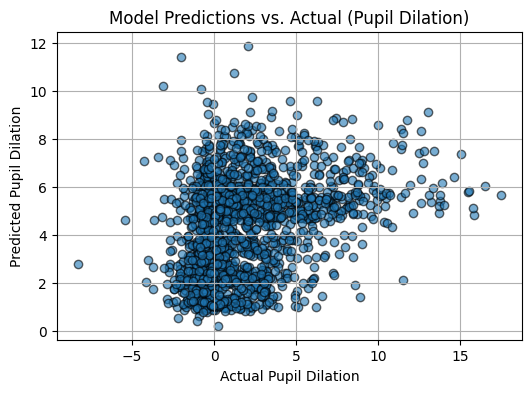

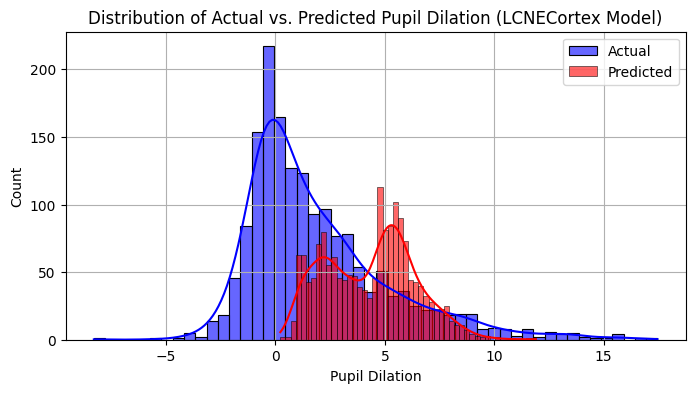

Pearson Correlation: 0.3281


In [12]:
batch_size = X_tensor.shape[0]
prev_LC = torch.zeros(batch_size, hidden_dim)
prev_Cortex = torch.zeros(batch_size, hidden_dim)
cell_state = torch.zeros(batch_size, hidden_dim)

with torch.no_grad():
    _, _, _, Pupil_pred, _ = model_lc_lstm(X_tensor, prev_LC, prev_Cortex, cell_state)

# Ensure predictions match the length of df_actual
min_length = min(len(df_actual), Pupil_pred.shape[0])

df_predictions = pd.DataFrame({'PupilPred': Pupil_pred.detach().cpu().numpy().reshape(-1)[:min_length]})
df_actual = df_actual.iloc[:min_length]

if "scaler_Y" in globals():
    # Clip predictions before inverse transformation
    df_predictions['PupilPred'] = np.clip(Pupil_pred.detach().cpu().numpy(), -1, 1)
    df_predictions['PupilPred'] = scaler_Y.inverse_transform(df_predictions[['PupilPred']])

plt.figure(figsize=(6, 4))
plt.scatter(df_actual['Event_PupilDilation'], df_predictions['PupilPred'], alpha=0.6, edgecolors="k")
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Predicted Pupil Dilation")
plt.title("Model Predictions vs. Actual (Pupil Dilation)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_actual['Event_PupilDilation'], kde=True, label="Actual", color='blue', alpha=0.6, bins=50)
sns.histplot(df_predictions['PupilPred'], kde=True, label="Predicted", color='red', alpha=0.6, bins=50)
plt.xlabel("Pupil Dilation")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Pupil Dilation (LCNECortex Model)")
plt.grid(True)
plt.show()

corr, _ = pearsonr(df_actual['Event_PupilDilation'], df_predictions['PupilPred'])
print(f"Pearson Correlation: {corr:.4f}")

# Analysis

## Analysis for Feed-Forward Neural Networks

In [13]:
input_size = X_tensor.shape[1]

with torch.no_grad():
    predictions, act1, act2 = model_ff(X_tensor, return_activations=True)

act1_np = act1.cpu().numpy()
act2_np = act2.cpu().numpy()
df_filtered = df_behavior.iloc[:X_tensor.shape[0]].copy()

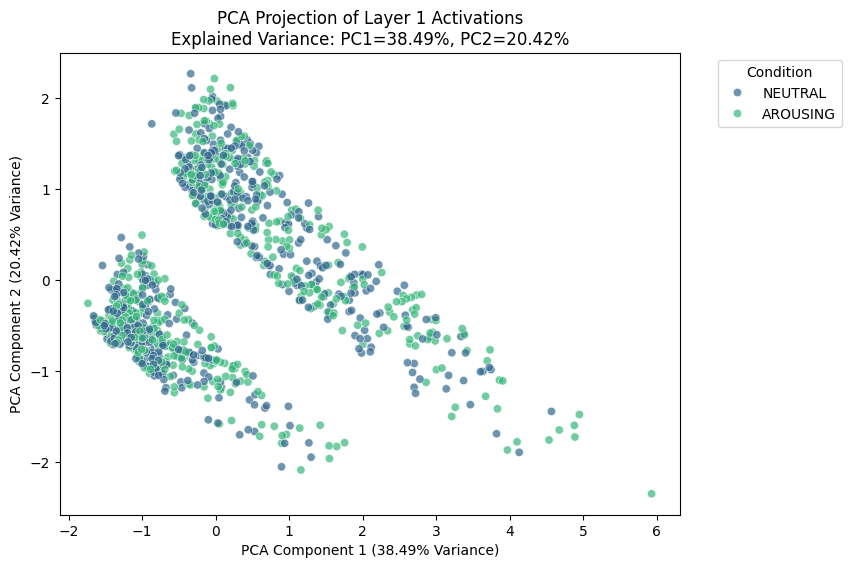

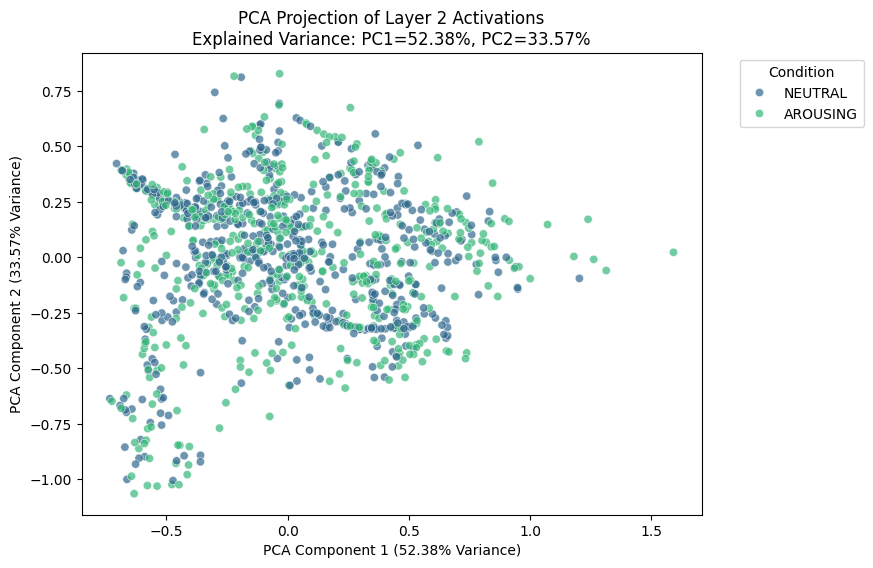

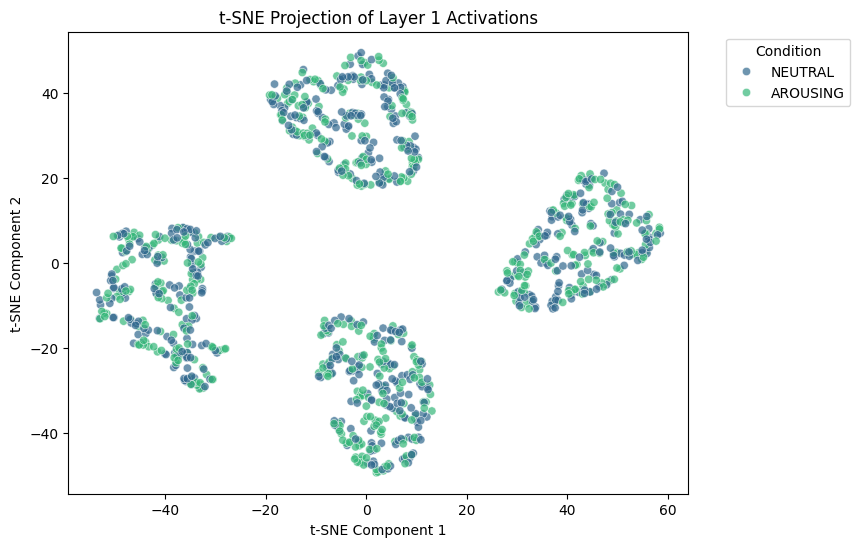

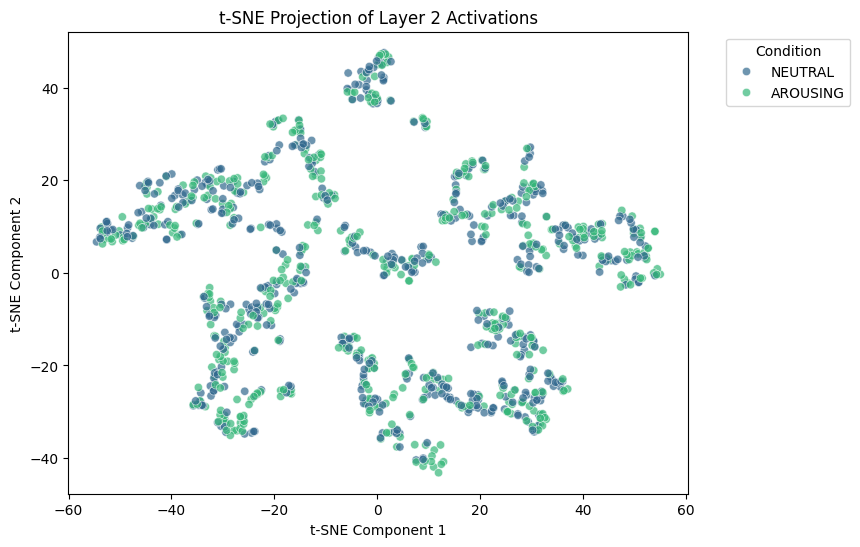

In [14]:
pca1 = PCA(n_components=2)
act1_pca = pca1.fit_transform(act1_np)
explained_variance1 = pca1.explained_variance_ratio_ * 100 

pca2 = PCA(n_components=2)
act2_pca = pca2.fit_transform(act2_np)
explained_variance2 = pca2.explained_variance_ratio_ * 100 

plt.figure(figsize=(8,6))
sns.scatterplot(x=act1_pca[:,0], y=act1_pca[:,1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)
plt.title(f"PCA Projection of Layer 1 Activations\nExplained Variance: PC1={explained_variance1[0]:.2f}%, PC2={explained_variance1[1]:.2f}%")
plt.xlabel(f"PCA Component 1 ({explained_variance1[0]:.2f}% Variance)")
plt.ylabel(f"PCA Component 2 ({explained_variance1[1]:.2f}% Variance)")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x=act2_pca[:,0], y=act2_pca[:,1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)
plt.title(f"PCA Projection of Layer 2 Activations\nExplained Variance: PC1={explained_variance2[0]:.2f}%, PC2={explained_variance2[1]:.2f}%")
plt.xlabel(f"PCA Component 1 ({explained_variance2[0]:.2f}% Variance)")
plt.ylabel(f"PCA Component 2 ({explained_variance2[1]:.2f}% Variance)")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
act1_tsne = tsne.fit_transform(act1_np)
act2_tsne = tsne.fit_transform(act2_np)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act1_tsne[:, 0], y=act1_tsne[:, 1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)
plt.title("t-SNE Projection of Layer 1 Activations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act2_tsne[:, 0], y=act2_tsne[:, 1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)
plt.title("t-SNE Projection of Layer 2 Activations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

## Analysis for Recurrent Networks

In [15]:
with torch.no_grad():
    _, hidden_states = model_rnn.rnn(X_rnn)
    act_rnn = hidden_states.squeeze(0).cpu().numpy()

print(f"RNN Hidden Activations Shape: {act_rnn.shape}")

RNN Hidden Activations Shape: (1699, 32)


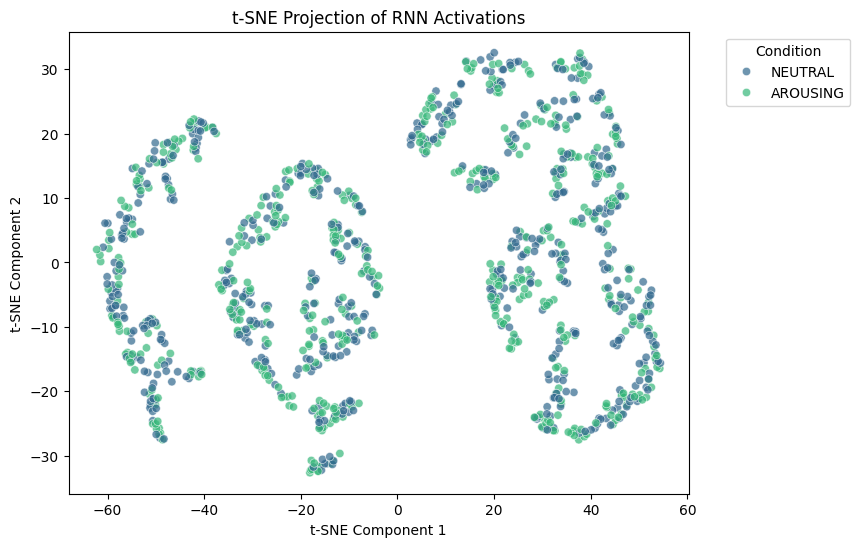

In [16]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
act_rnn_tsne = tsne.fit_transform(act_rnn)

df_filtered = df_behavior.iloc[:act_rnn.shape[0]].copy()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_rnn_tsne[:, 0], y=act_rnn_tsne[:, 1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)

plt.title("t-SNE Projection of RNN Activations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

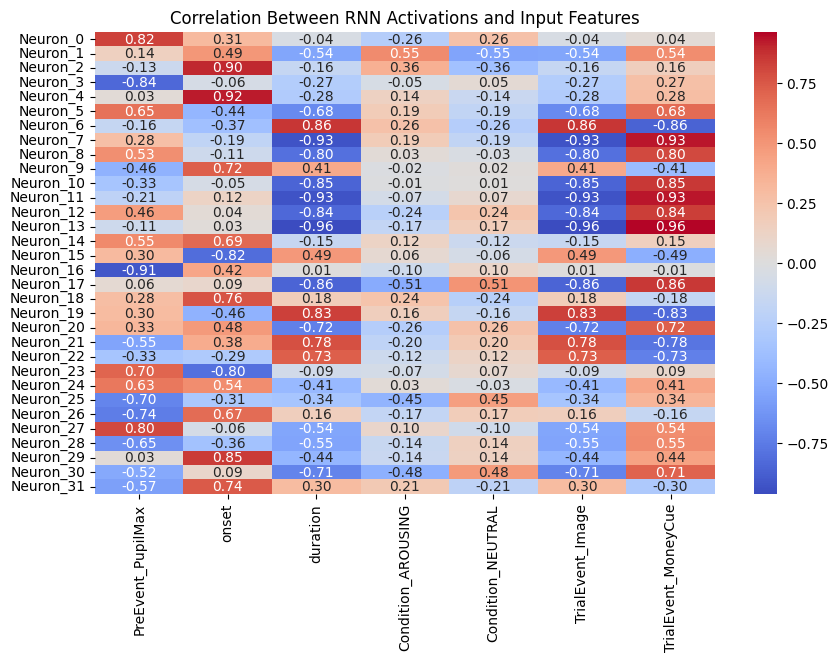

In [17]:
df_activations = pd.DataFrame(act_rnn, columns=[f"Neuron_{i}" for i in range(act_rnn.shape[1])])

df_correlation = pd.concat([df_activations, X], axis=1).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(df_correlation.iloc[:act_rnn.shape[1], act_rnn.shape[1]:], cmap="coolwarm", annot=True, fmt=".2f")

plt.title("Correlation Between RNN Activations and Input Features")
plt.show()

## Analysis for LCNECortex Model

We will see that, though  under fitted with the real data, there are some structureness to the data that we can play around with since we injected mechanistic insights into it.

In [18]:
with torch.no_grad():
    prev_LC = torch.zeros(X_tensor.shape[0], model_lc.hidden_dim)
    prev_Cortex = torch.zeros(X_tensor.shape[0], model_lc.hidden_dim)

    LC_act, NE_act, C_act, Pupil_pred, LC_raw, NE_raw, C_raw = model_lc(X_tensor, prev_LC, prev_Cortex, return_activations=True)

# Convert activations to numpy
act_lc = LC_act.cpu().numpy()
act_ne = NE_act.cpu().numpy()
act_cortex = C_act.cpu().numpy()

# Create DataFrame for analysis
df_activations = pd.DataFrame({
    'LC_Mean': act_lc.mean(axis=1),
    'NE_Mean': act_ne.mean(axis=1),
    'Cortex_Mean': act_cortex.mean(axis=1),
    'PupilPred': Pupil_pred.cpu().numpy().squeeze(),
    'ActualPupil': df_clean['Event_PupilDilation'].values  # Ensure this aligns with X_tensor
})

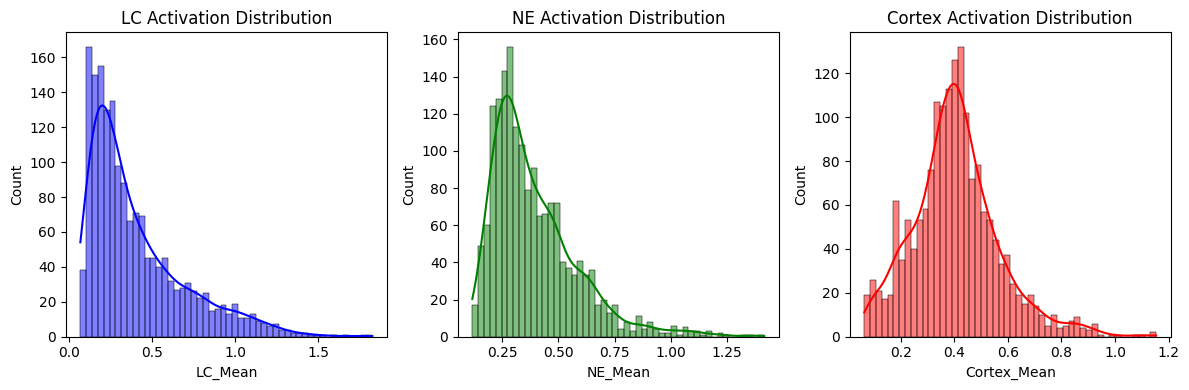

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(df_activations['LC_Mean'], kde=True, bins=50, color='blue')
plt.title("LC Activation Distribution")

plt.subplot(1, 3, 2)
sns.histplot(df_activations['NE_Mean'], kde=True, bins=50, color='green')
plt.title("NE Activation Distribution")

plt.subplot(1, 3, 3)
sns.histplot(df_activations['Cortex_Mean'], kde=True, bins=50, color='red')
plt.title("Cortex Activation Distribution")

plt.tight_layout()
plt.show()


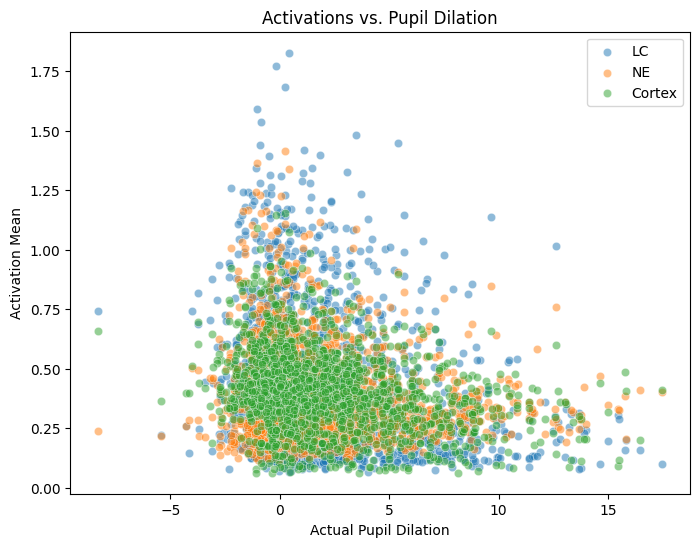

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_activations['ActualPupil'], y=df_activations['LC_Mean'], alpha=0.5, label="LC")
sns.scatterplot(x=df_activations['ActualPupil'], y=df_activations['NE_Mean'], alpha=0.5, label="NE")
sns.scatterplot(x=df_activations['ActualPupil'], y=df_activations['Cortex_Mean'], alpha=0.5, label="Cortex")
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Activation Mean")
plt.title("Activations vs. Pupil Dilation")
plt.legend()
plt.show()

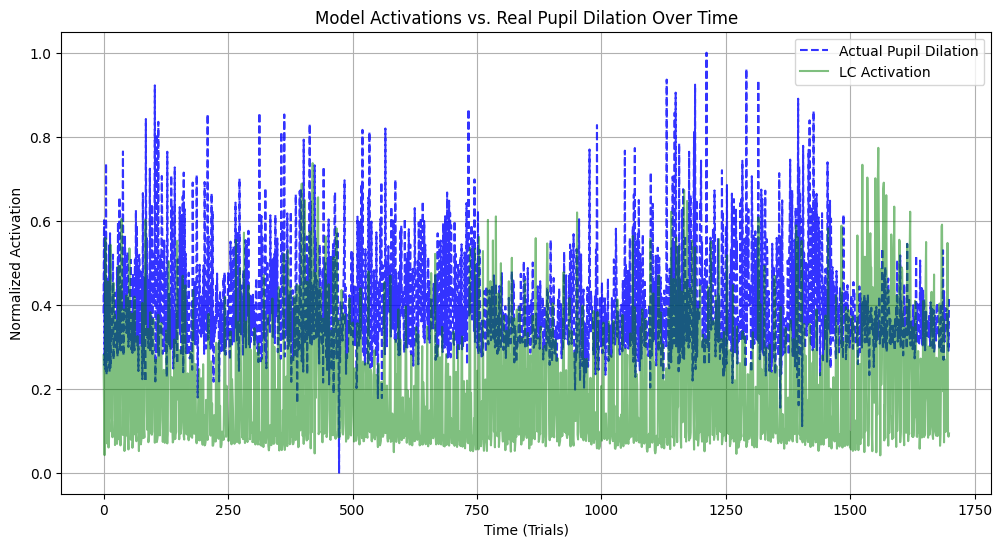

Correlation with Actual Pupil Dilation:
LC Activation: -0.067
NE Activation: 0.002
Cortex Activation: 0.026
Predicted Pupil Dilation: 0.497


In [21]:
with torch.no_grad():
    LC_activations, NE_activations, C_activations, Pupil_pred = model_lc(
        X_tensor, torch.zeros(X_tensor.shape[0], 8), torch.zeros(X_tensor.shape[0], 8)
    )

act_lc = LC_activations.cpu().numpy().squeeze()
act_ne = NE_activations.cpu().numpy().squeeze()
act_cortex = C_activations.cpu().numpy().squeeze()
pupil_pred = Pupil_pred.cpu().numpy().squeeze()

pupil_actual = df_clean["Event_PupilDilation"].values
time_axis = np.arange(len(pupil_actual))  # Time index

scaler_pupil = MinMaxScaler(feature_range=(0, 1))
pupil_actual_scaled = scaler_pupil.fit_transform(pupil_actual.reshape(-1, 1)).squeeze()
pupil_pred_scaled = scaler_pupil.transform(pupil_pred.reshape(-1, 1)).squeeze()

scaler_lc = MinMaxScaler(feature_range=(0, 1))
act_lc_scaled = scaler_lc.fit_transform(act_lc.reshape(-1, 1)).squeeze()

scaler_ne = MinMaxScaler(feature_range=(0, 1))
act_ne_scaled = scaler_ne.fit_transform(act_ne.reshape(-1, 1)).squeeze()

scaler_cortex = MinMaxScaler(feature_range=(0, 1))
act_cortex_scaled = scaler_cortex.fit_transform(act_cortex.reshape(-1, 1)).squeeze()

# Ensure all variables have the same length
min_length = min(len(time_axis), len(pupil_actual_scaled), len(pupil_pred_scaled), 
                 len(act_lc_scaled), len(act_ne_scaled), len(act_cortex_scaled))

time_axis = time_axis[:min_length]
pupil_actual_scaled = pupil_actual_scaled[:min_length]
pupil_pred_scaled = pupil_pred_scaled[:min_length]
act_lc_scaled = act_lc_scaled[:min_length]
act_ne_scaled = act_ne_scaled[:min_length]
act_cortex_scaled = act_cortex_scaled[:min_length]


plt.figure(figsize=(12, 6))

sns.lineplot(x=time_axis, y=pupil_actual_scaled, label="Actual Pupil Dilation", color='blue', linestyle="dashed", alpha=0.8)
sns.lineplot(x=time_axis, y=act_lc_scaled, label="LC Activation", color='green', alpha=0.5)
# sns.lineplot(x=time_axis, y=act_ne_scaled, label="NE Activation", color='purple', alpha=0.5)
# sns.lineplot(x=time_axis, y=act_cortex_scaled, label="Cortex Activation", color='orange', alpha=0.5)

plt.xlabel("Time (Trials)")
plt.ylabel("Normalized Activation")
plt.title("Model Activations vs. Real Pupil Dilation Over Time")
plt.legend()
plt.grid(True)
plt.show()

lc_corr = pearsonr(act_lc_scaled, pupil_actual_scaled)[0]
ne_corr = pearsonr(act_ne_scaled, pupil_actual_scaled)[0]
cortex_corr = pearsonr(act_cortex_scaled, pupil_actual_scaled)[0]
pupil_pred_corr = pearsonr(pupil_pred_scaled, pupil_actual_scaled)[0]
print(f"Correlation with Actual Pupil Dilation:")
print(f"LC Activation: {lc_corr:.3f}")
print(f"NE Activation: {ne_corr:.3f}")
print(f"Cortex Activation: {cortex_corr:.3f}")
print(f"Predicted Pupil Dilation: {pupil_pred_corr:.3f}")

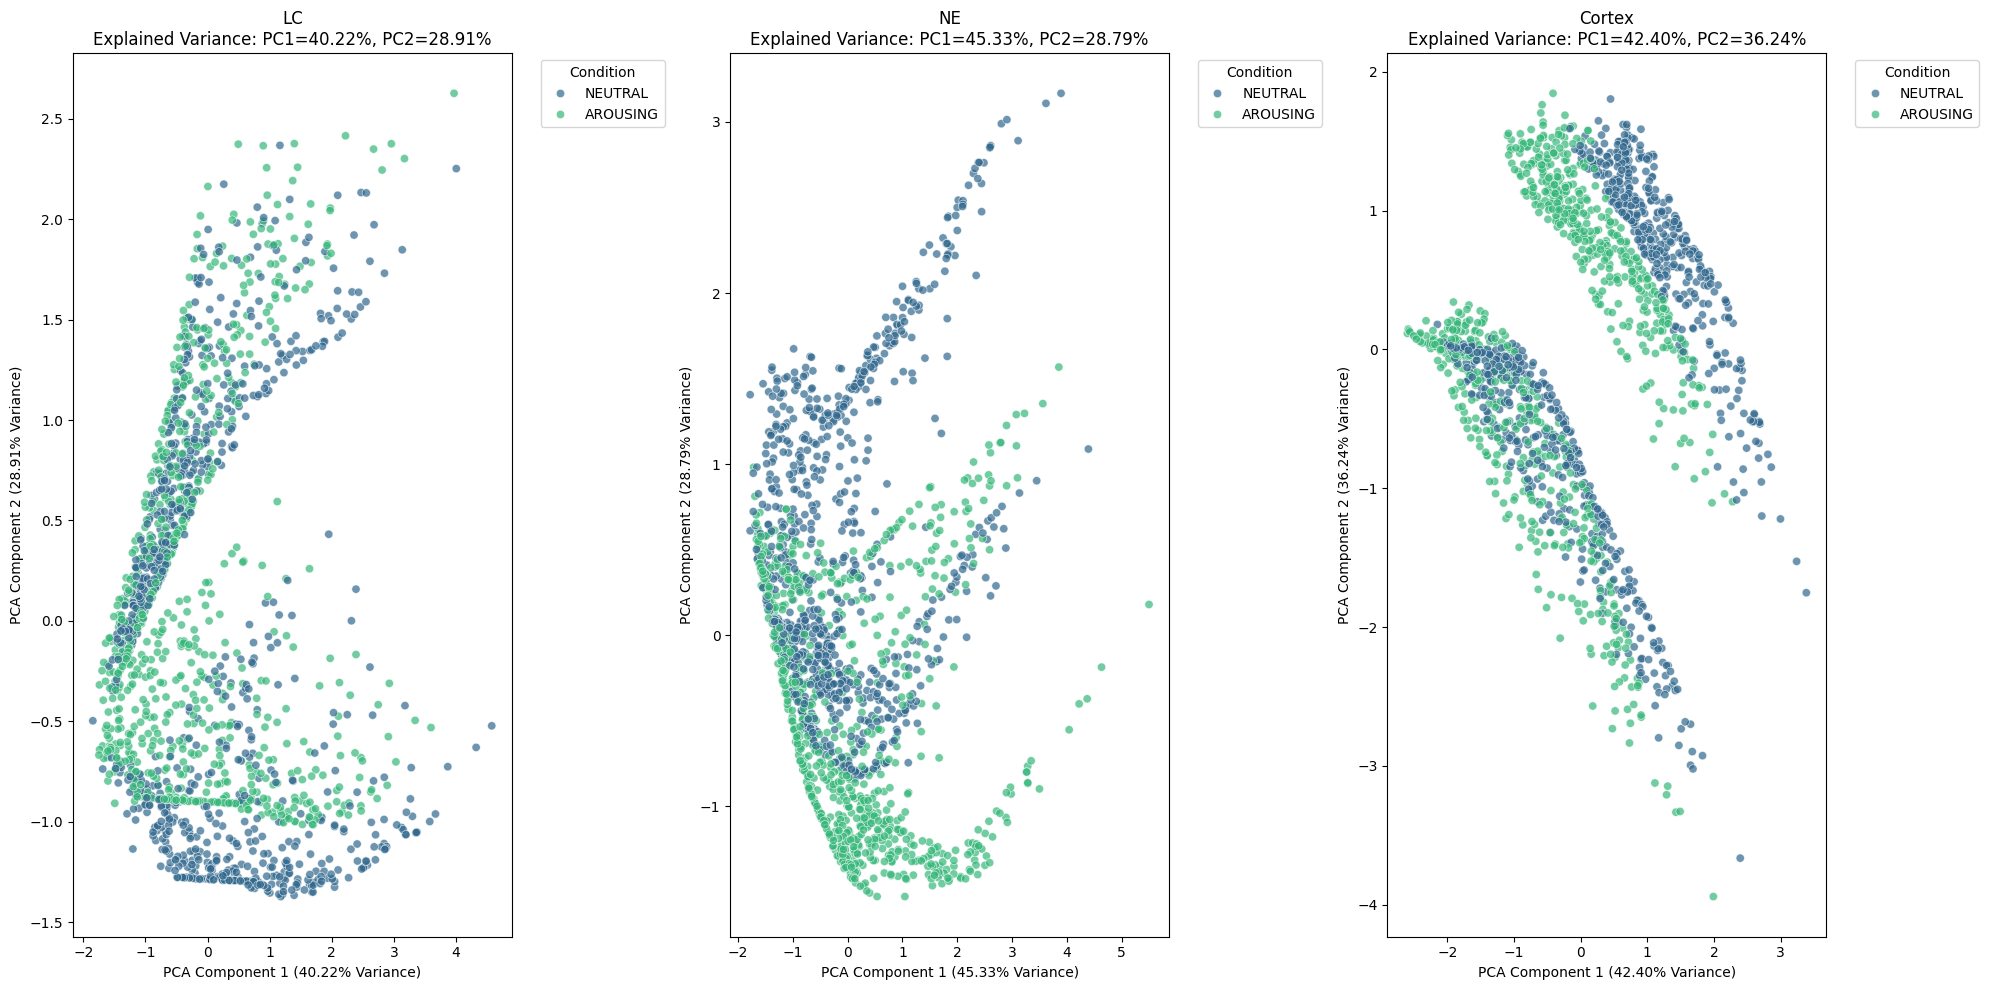

In [22]:
activations_list = [act_lc, act_ne, act_cortex]
labels = ["LC", "NE", "Cortex"]

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes = axes.flatten()

for i, (activation, label) in enumerate(zip(activations_list, labels)):
    pca = PCA(n_components=2)
    act_pca = pca.fit_transform(activation)
    explained_variance = pca.explained_variance_ratio_ * 100
    
    ax = axes[i]
    sns.scatterplot(x=act_pca[:, 0], y=act_pca[:, 1], hue=df_clean["Condition"], palette="viridis", alpha=0.7, ax=ax)
    ax.set_title(f"{label}\nExplained Variance: PC1={explained_variance[0]:.2f}%, PC2={explained_variance[1]:.2f}%")
    ax.set_xlabel(f"PCA Component 1 ({explained_variance[0]:.2f}% Variance)")
    ax.set_ylabel(f"PCA Component 2 ({explained_variance[1]:.2f}% Variance)")
    ax.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

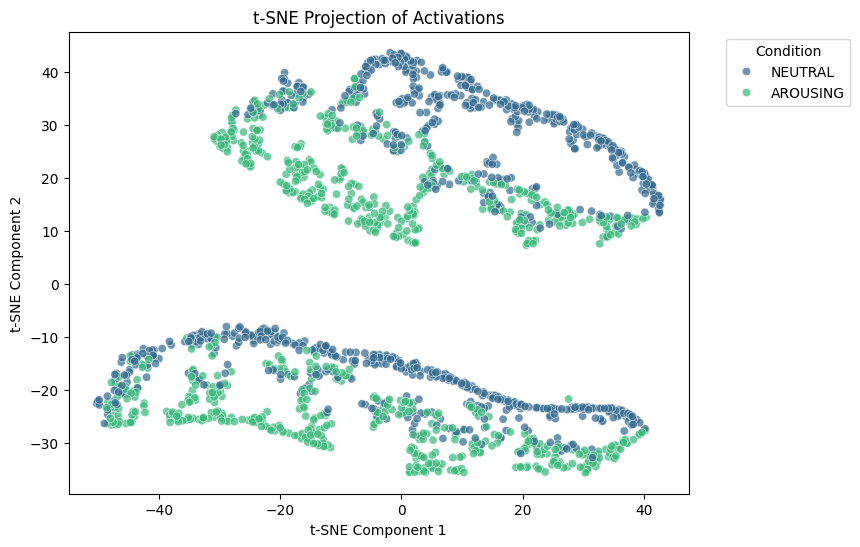

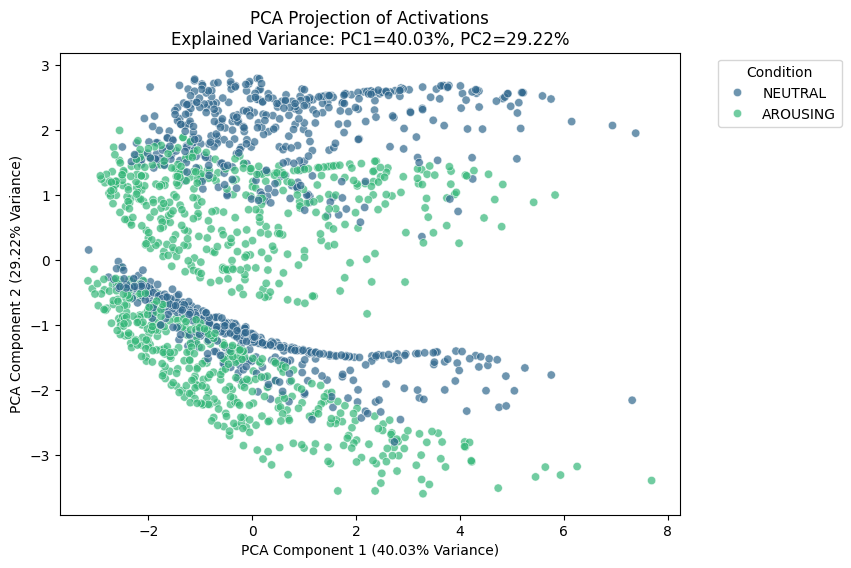

In [23]:
# Concatenate activations
act_combined = np.hstack([act_lc, act_ne, act_cortex])

pca = PCA(n_components=2)
act_pca = pca.fit_transform(act_combined)
explained_variance = pca.explained_variance_ratio_ * 100

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
act_tsne = tsne.fit_transform(act_pca)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_tsne[:, 0], y=act_tsne[:, 1], hue=df_clean["Condition"], palette="viridis", alpha=0.7)
plt.title("t-SNE Projection of Activations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_pca[:, 0], y=act_pca[:, 1], hue=df_clean["Condition"], palette="viridis", alpha=0.7)
plt.title(f"PCA Projection of Activations\nExplained Variance: PC1={explained_variance[0]:.2f}%, PC2={explained_variance[1]:.2f}%")
plt.xlabel(f"PCA Component 1 ({explained_variance[0]:.2f}% Variance)")
plt.ylabel(f"PCA Component 2 ({explained_variance[1]:.2f}% Variance)")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

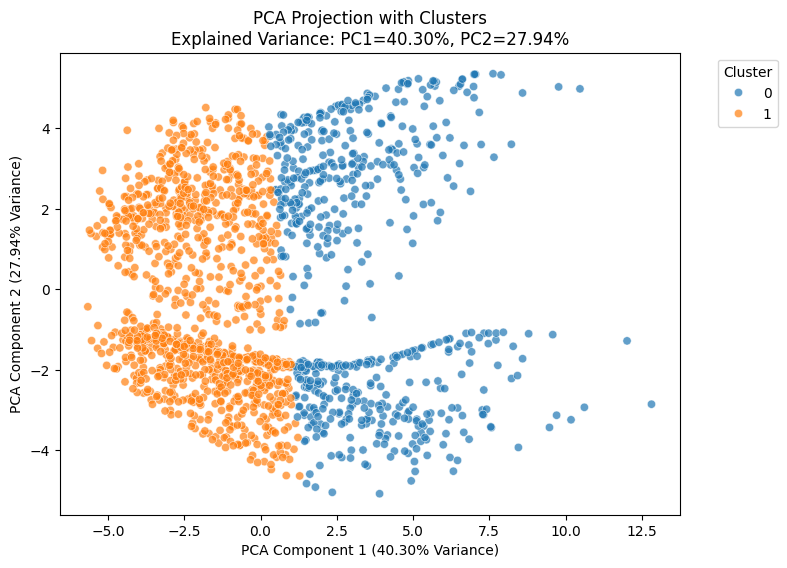

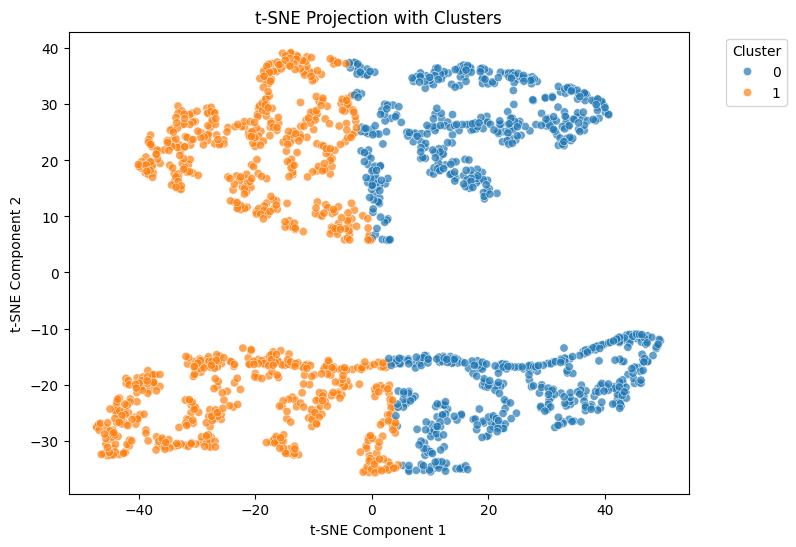

In [24]:
scaler = StandardScaler()
act_combined = scaler.fit_transform(np.hstack([act_lc, act_ne, act_cortex]))

pca = PCA(n_components=2)
act_pca = pca.fit_transform(act_combined)
explained_variance = pca.explained_variance_ratio_ * 100

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
act_tsne = tsne.fit_transform(act_pca)

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters_pca = kmeans.fit_predict(act_pca)
clusters_tsne = kmeans.predict(act_tsne)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_pca[:, 0], y=act_pca[:, 1], hue=clusters_pca, palette="tab10", alpha=0.7)
plt.title(f"PCA Projection with Clusters\nExplained Variance: PC1={explained_variance[0]:.2f}%, PC2={explained_variance[1]:.2f}%")
plt.xlabel(f"PCA Component 1 ({explained_variance[0]:.2f}% Variance)")
plt.ylabel(f"PCA Component 2 ({explained_variance[1]:.2f}% Variance)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_tsne[:, 0], y=act_tsne[:, 1], hue=clusters_tsne, palette="tab10", alpha=0.7)
plt.title("t-SNE Projection with Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

## LSTM LCNECortex Model

In [25]:
model_lc_lstm.eval()
with torch.no_grad():
    prev_LC = torch.zeros(X_tensor.shape[0], model_lc_lstm.hidden_dim)
    prev_Cortex = torch.zeros(X_tensor.shape[0], model_lc_lstm.hidden_dim)
    cell_state = torch.zeros(X_tensor.shape[0], model_lc_lstm.hidden_dim)

    LC_act, NE_act, C_act, Pupil_pred, forget_gate, input_gate, output_gate, cell_state = model_lc_lstm(
        X_tensor, prev_LC, prev_Cortex, cell_state, return_activations=True
    )

act_lc = LC_act.cpu().numpy()
act_ne = NE_act.cpu().numpy()
act_cortex = C_act.cpu().numpy()
pupil_pred = Pupil_pred.cpu().numpy().squeeze()
forget_gate_np = forget_gate.cpu().numpy()
input_gate_np = input_gate.cpu().numpy()
output_gate_np = output_gate.cpu().numpy()
cell_state_np = cell_state.cpu().numpy()

df_activations = pd.DataFrame({
    'LC_Mean': act_lc.mean(axis=1), 'LC_Var': act_lc.var(axis=1),
    'NE_Mean': act_ne.mean(axis=1), 'NE_Var': act_ne.var(axis=1),
    'Cortex_Mean': act_cortex.mean(axis=1), 'Cortex_Var': act_cortex.var(axis=1),
    'ForgetGate_Mean': forget_gate_np.mean(axis=1), 'ForgetGate_Var': forget_gate_np.var(axis=1),
    'InputGate_Mean': input_gate_np.mean(axis=1), 'InputGate_Var': input_gate_np.var(axis=1),
    'OutputGate_Mean': output_gate_np.mean(axis=1), 'OutputGate_Var': output_gate_np.var(axis=1),
    'CellState_Mean': cell_state_np.mean(axis=1), 'CellState_Var': cell_state_np.var(axis=1),
    'PupilPred': pupil_pred.mean(axis=1),
})

In [26]:
act_lc.mean(axis=1).shape, input_gate_np.mean(axis=1).shape, pupil_pred.shape

((1699,), (1699,), (1699, 8))

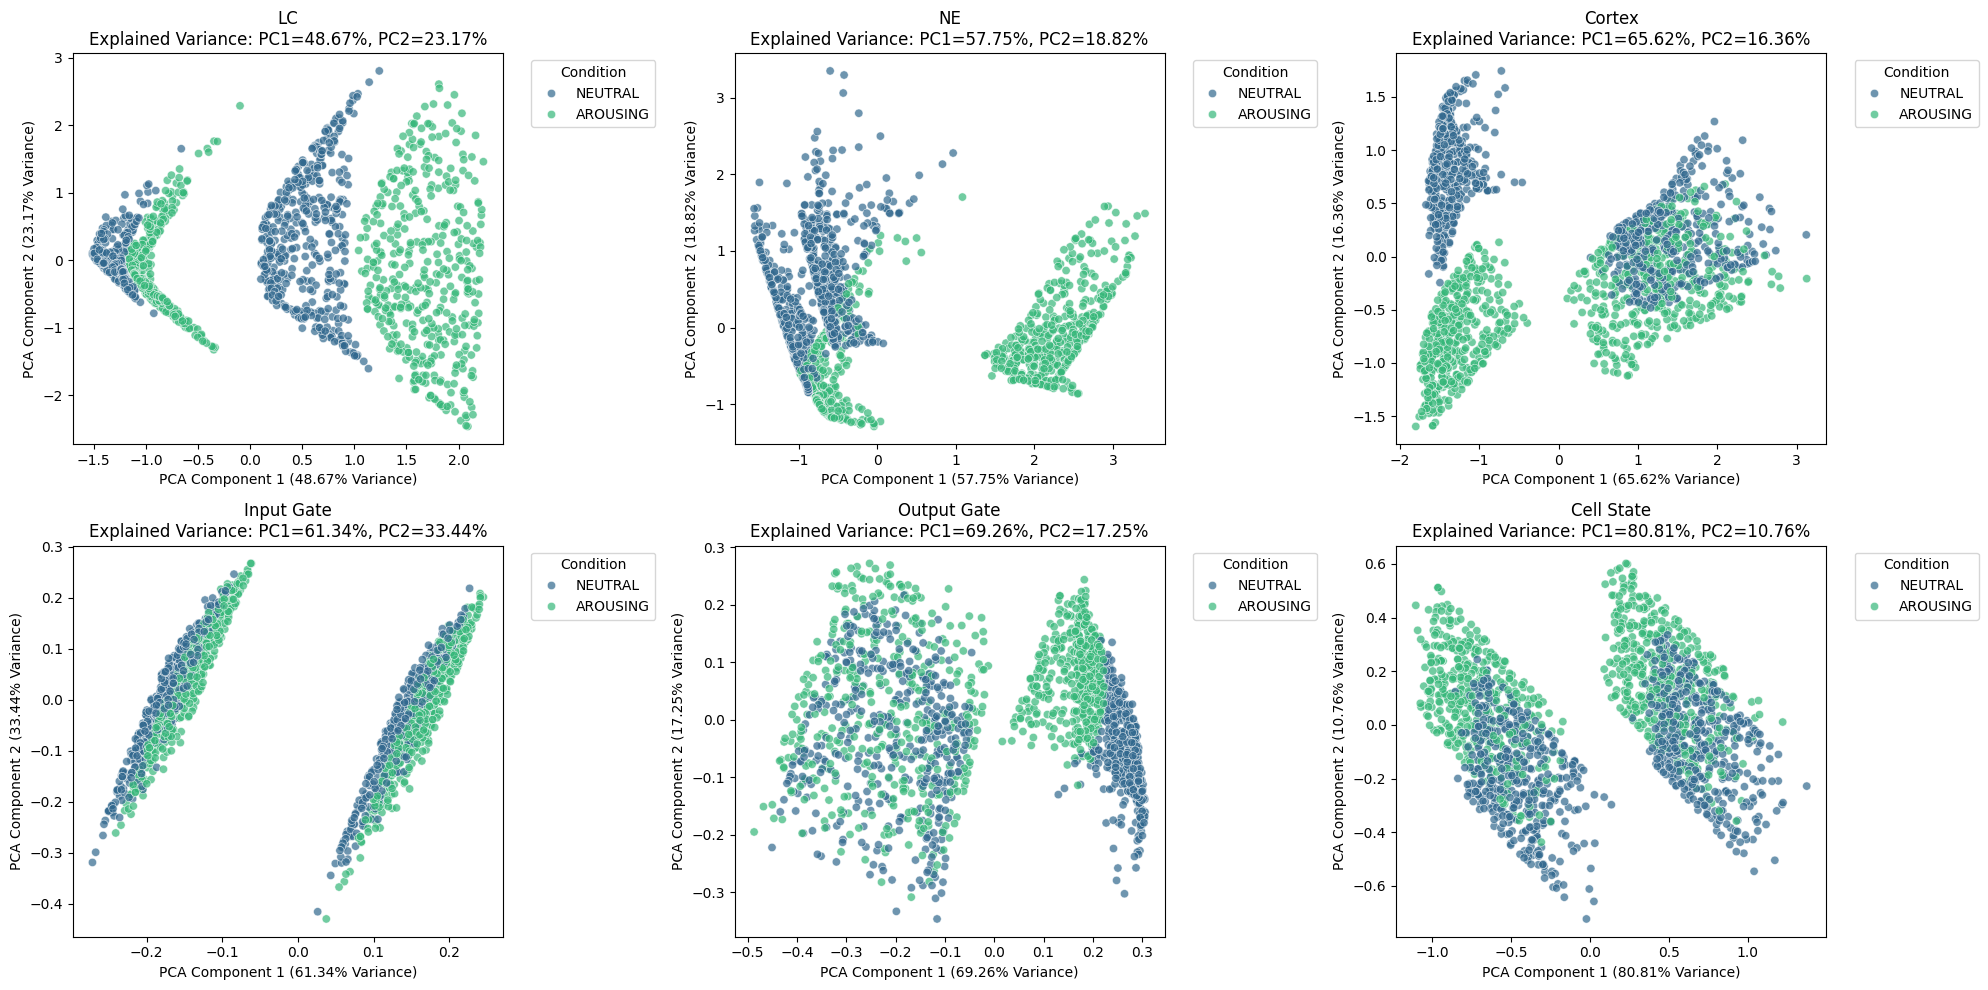

In [27]:
activations_list = [act_lc, act_ne, act_cortex, input_gate_np, output_gate_np, cell_state_np]
labels = ["LC", "NE", "Cortex", "Input Gate", "Output Gate", "Cell State"]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i, (activation, label) in enumerate(zip(activations_list, labels)):
    pca = PCA(n_components=2)
    act_pca = pca.fit_transform(activation)
    explained_variance = pca.explained_variance_ratio_ * 100
    
    ax = axes[i]
    sns.scatterplot(x=act_pca[:, 0], y=act_pca[:, 1], hue=df_clean["Condition"], palette="viridis", alpha=0.7, ax=ax)
    ax.set_title(f"{label}\nExplained Variance: PC1={explained_variance[0]:.2f}%, PC2={explained_variance[1]:.2f}%")
    ax.set_xlabel(f"PCA Component 1 ({explained_variance[0]:.2f}% Variance)")
    ax.set_ylabel(f"PCA Component 2 ({explained_variance[1]:.2f}% Variance)")
    ax.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()